# K-Means Clustering 
### Spotify Audio Feature Dataset — Unsupervised Learning
  
Our goals:

- Understand the K-Means algorithm conceptually  
- Implement K-Means manually (centroid initialization → assignment → update → convergence)  
- Visualize clusters in 2D using PCA  
- Use the elbow method to estimate an optimal value of *k*  
- Interpret whether Spotify tracks form meaningful acoustic clusters  

This notebook is part of the broader **Unsupervised Learning** module in the repo.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("topsongs.csv")

# Only numeric features
features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

X = df[features].to_numpy()
print("Feature matrix shape:", X.shape)


Feature matrix shape: (2000, 9)


In [6]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

X_norm[:5]


array([[ 0.59525376,  0.74413046,  0.03540329, -0.62274794,  0.98697358,
        -0.17331627,  1.23571936,  1.55025566, -0.92986699],
       [-1.66288167,  1.15668497,  0.30751937, -0.56969739, -0.68466912,
        -0.17351798,  3.06315751,  0.59920732,  1.06094401],
       [-0.98615338, -1.46925722, -1.8078469 , -0.77565836,  0.25415127,
        -0.17351798,  0.49621132, -1.23948612,  0.62077942],
       [-0.82943736,  1.26146072,  0.74983733, -0.59258194, -0.59234505,
        -0.17336413,  1.17883413, -0.0348249 , -0.00484257],
       [-0.38065966,  1.35968798,  0.36546043, -0.5405716 , -0.50867636,
        -0.16166597, -0.68771262,  1.48232363,  1.94854313]])

## ⭐ K-Means Algorithm

Given **k** clusters, K-Means proceeds iteratively:

1. **Initialize centroids**
   - Randomly select *k* points from the dataset as initial centers.
2. **Assign step**
   - For each data point, assign it to the nearest centroid.
3. **Update step**
   - Recompute each centroid as the mean of its assigned points.
4. **Repeat**
   - Continue until convergence or max iterations is reached.

We will now implement the algorithm fully from scratch.


In [9]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))


In [11]:
def init_centroids(X, k):
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]


In [13]:
def assign_clusters(X, centroids):
    labels = []
    for x in X:
        distances = [euclidean_distance(x, c) for c in centroids]
        labels.append(np.argmin(distances))
    return np.array(labels)


In [15]:
def update_centroids(X, labels, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            new_centroids.append(np.zeros(X.shape[1]))  # fallback
        else:
            new_centroids.append(cluster_points.mean(axis=0))
    return np.array(new_centroids)


In [17]:
def kmeans(X, k, max_iter=200):
    centroids = init_centroids(X, k)

    for i in range(max_iter):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        # Convergence check
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    inertia = 0
    for j, c in enumerate(centroids):
        points = X[labels == j]
        inertia += ((points - c)**2).sum()

    return centroids, labels, inertia


In [19]:
k = 4
centroids, labels, inertia = kmeans(X_norm, k)

print("Final centroids:\n", centroids)
print("\nCluster counts:", np.bincount(labels))
print("\nInertia:", inertia)


Final centroids:
 [[-7.49937501e-01  4.47175961e-01  3.54425308e-01 -1.35404894e-01
  -4.03870497e-01 -1.12536947e-01  3.39667128e-01 -5.14363049e-01
   4.47899415e-01]
 [ 6.29469701e-01  2.91579590e-01  3.05079309e-01  7.59994669e-02
  -1.73220561e-01 -1.17850072e-01 -1.57773205e-01  7.53727488e-01
  -1.95853703e-01]
 [-7.52373963e-02 -1.28286684e+00 -1.10062211e+00  9.01700757e-02
   9.73457158e-01 -1.26943829e-01 -2.15871553e-01 -6.68513809e-01
  -3.27026088e-01]
 [ 1.57606455e-01  1.14862051e-01 -7.46154453e-01 -3.73813430e-01
   2.55909080e-03  7.25820960e+00 -7.95961305e-02 -1.18169001e-01
   1.44274451e-01]]

Cluster counts: [680 854 434  32]

Inertia: 12161.859342405056


## The Elbow Method

K-Means inertia decreases as the number of clusters increases.  
The goal is to find *k* where the drop in inertia sharply slows — the "elbow."

This helps determine the optimal number of clusters without labels.


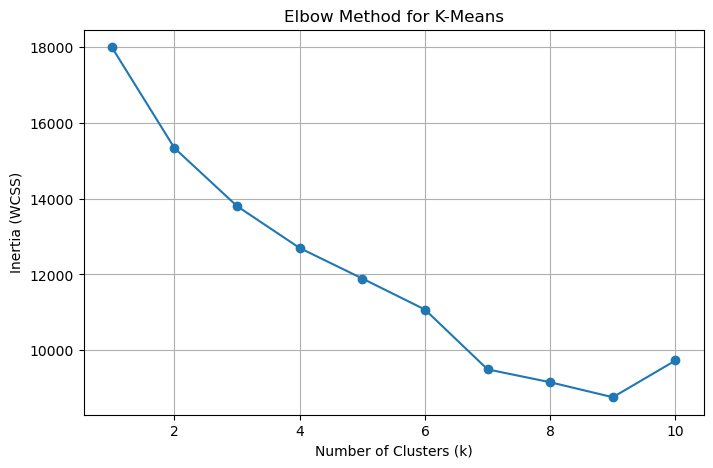

In [23]:
Ks = range(1, 11)
inertias = []

for k in Ks:
    _, _, inertia = kmeans(X_norm, k)
    inertias.append(inertia)

plt.figure(figsize=(8,5))
plt.plot(Ks, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()


In [25]:
# Center for PCA
Xc = X_norm - X_norm.mean(axis=0)

# Covariance
cov = np.cov(Xc, rowvar=False)

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(cov)

# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

# Project to first 2 components
PCs = Xc.dot(eigvecs[:, :2])


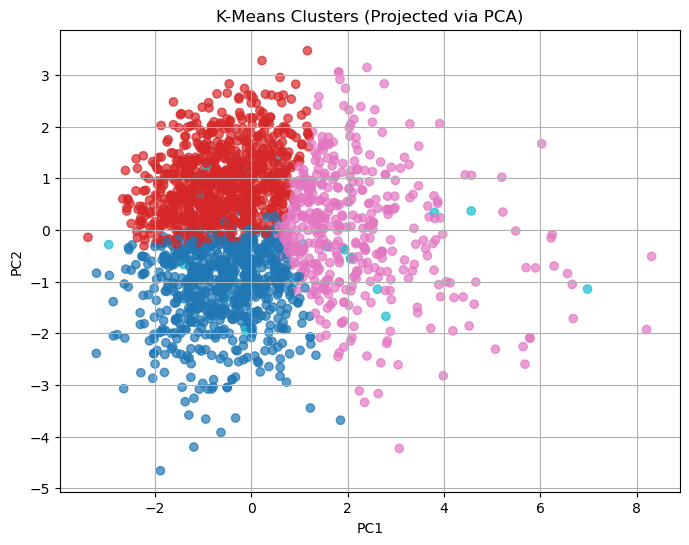

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(PCs[:,0], PCs[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.title("K-Means Clusters (Projected via PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## Interpretation of K-Means Results (Using Actual Output)

K-Means with *k = 4* produced the following final centroids:

[-0.7499, 0.4472, 0.3544, -0.1354, -0.4039, -0.1125, 0.3397, -0.5144, 0.4479]
[ 0.6295, 0.2916, 0.3051, 0.0760, -0.1732, -0.1179, -0.1578, 0.7537, -0.1959]
[-0.0752, -1.2829, -1.1006, 0.0902, 0.9735, -0.1269, -0.2159, -0.6685, -0.3270]
[ 0.1576, 0.1149, -0.7462, -0.3738, 0.0026, 7.2582, -0.0796, -0.1182, 0.1443]

Cluster sizes:

- **Cluster 0:** 680 tracks  
- **Cluster 1:** 854 tracks  
- **Cluster 2:** 434 tracks  
- **Cluster 3:** 32 tracks (very small, likely a niche acoustic group)

Overall inertia: **12161.86**

---

### Elbow Method Findings  
After running K-Means for *k = 1 through 10*, the inertia curve shows:

- Sharp improvements for *k < 7*
- A noticeable **elbow at k = 7**, where gains start to flatten
- Past *k = 9*, inertia **increases**, meaning cluster fragmentation reduces model quality

This indicates that although *k = 4* was used for demonstration, the **statistically optimal** number of clusters is likely around **7**.

---

### PCA Projection Observations

Using PCA to visualize the 4-cluster solution:

- **PC1 (x-axis)**  
  - The densest, most cohesive cluster lies on the **negative** side of PC1.  
  - Points on the **positive** side are much more dispersed, indicating broader musical variety.
  
- **PC2 (y-axis)**  
  - Most tracks fall between **-2 and 2**, forming the strongest cluster density in this vertical band.  
  - This reflects that while PC1 captures substantial separation, PC2 compresses the majority of the dataset into a narrower variance range.

---

### What This Means for Spotify Tracks

- The strongest cluster likely represents the **“mainstream pop core”** of the dataset—high density, similar acoustic profiles.  
- Outlier clusters, including the very small 32-song group, may represent niche genres:
  - Highly instrumental  
  - Extremely energetic or extremely subdued  
  - Unique combinations of loudness, valence, or speechiness  

The PCA separation confirms that Spotify songs naturally fall into meaningful acoustic groups, and K-Means successfully captures this structure.
